In [1]:
import pandas as pd
import numpy as np
import json
import folium
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

## Loading raw sensor data aggregated in every 10-minutes

In [6]:
with open('../data/sensors/minute.json') as json_file:  
    sensors = json.load(json_file)

## Grouping sensor data by calculating mean and std_deviation of each sensor over the years

In [7]:
correlationDF = pd.DataFrame()
sensorCoordinates = pd.DataFrame()

for sensorID in sensors:
    
    # Creating empty dataframe
    currentDF = pd.DataFrame()
    
    # Extracting timeseries from JSON
    timeseries = sensors[sensorID]['data']
    # Extracting sensor coords
    coords = sensors[sensorID]['latlng']
    
    # Saving sensor Coords
    sensorCoordinates = sensorCoordinates.append({'sensorID': sensorID, 'lat':coords[0], 'lng':coords[1]}, ignore_index = True)
    
    # Transforming timeseries into a dataframe
    currentDF = currentDF.append(timeseries)
    
    # Converting epoch to datetime
    currentDF['ts'] = pd.to_datetime(currentDF['ts'],unit='s')
    
    # Calculating dbas
    currentDF['dbas'] = currentDF['sum'] / currentDF['count']
    
    # Extracting dayofhyear, hour, minute
    currentDF['dayofyear'] = currentDF['ts'].dt.dayofyear
    currentDF['hour'] = currentDF['ts'].dt.hour
    currentDF['minute'] = currentDF['ts'].dt.minute
    
    # Removing unnecessary columns
    currentDF = currentDF[['ts', 'hour','minute', 'dbas', 'dayofyear']]
    
    # groupby minute of the day
    currentDF = currentDF.groupby(['hour', 'minute']).mean()
  
    
    hour_aggregation_max = currentDF.groupby(['hour']).max()
    hour_aggregation_min = currentDF.groupby(['hour']).min()
    aggregation = hour_aggregation_max[['dbas']] - hour_aggregation_min[['dbas']]
    
    correlationDF = correlationDF.append({'sensorID': sensorID, 'mean':aggregation['dbas'].mean(), 'std':aggregation['dbas'].std()}, ignore_index=True)

- Fixing the broken coordinates (e.g. [0.0, 0.0])

In [8]:
filename = '../data/sensors/sensor_coords.txt'

f = open(filename)

for line in f:
    sonycID, lat, lng = line.split(' ')
    sensorCoordinates[sensorCoordinates['sensorID'] == sonycID]['lat'] = lat
    sensorCoordinates[sensorCoordinates['sensorID'] == sonycID]['lng'] = lng

/Users/jlrulff/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/jlrulff/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Correlation chart

- Chart used to elucidate the correlation between the mean and standard deviation of each sensor
- Also useful to identify potential datasets with broken data

test


/Users/jlrulff/anaconda3/lib/python3.6/site-packages/altair/utils/core.py:294: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  attrs['type'] = infer_vegalite_type(data[attrs['field']])


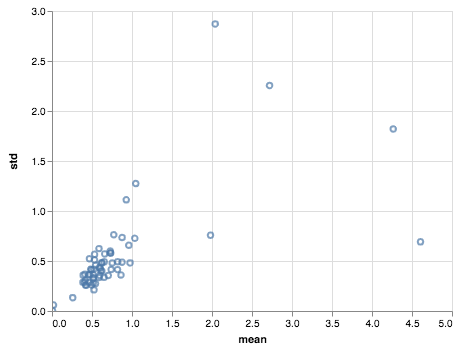

In [9]:
printCorrelationPlot(correlationDF, 'test')

- Removing the outliers identified in the previous chart

test


/Users/jlrulff/anaconda3/lib/python3.6/site-packages/altair/utils/core.py:294: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  attrs['type'] = infer_vegalite_type(data[attrs['field']])


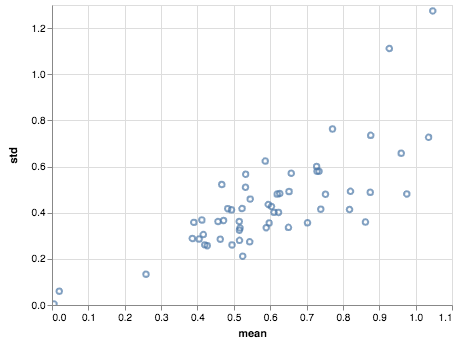

In [10]:
printCorrelationPlot(correlationDF[ (correlationDF['mean'] < 1.5) & (correlationDF['std'] < 1.5)], 'test')

In [11]:
correlationGrid = pd.DataFrame()

# for meanBucket in frange(0, 1.5, 0.1):
#     for stdBucket in frange(0, 1.5, 0.1):

currentmeanBucket = 0.0
currentstdBucket = 0.0
gridID = 0

while(currentmeanBucket <= 1.5):
    
    nextMeanBucket = currentmeanBucket + 0.2
    
    while(currentstdBucket <= 1.5):
        
        nextStdBucket = currentstdBucket + 0.2
        
        step = correlationDF[ (correlationDF['mean'] > currentmeanBucket) & (correlationDF['mean'] < nextMeanBucket) ]
        step = step[ (correlationDF['std'] > currentstdBucket) & (correlationDF['std'] < nextStdBucket)]
        
        currentstdBucket = nextStdBucket
        
        if step.shape[0] > 0:
            correlationGrid = correlationGrid.append({'stdBucket': currentstdBucket, 'meanBucket': currentmeanBucket, 'sensors':step['sensorID'].values , 'nSensors':len(step['sensorID'].values)}, ignore_index = True)
        else:
            correlationGrid = correlationGrid.append({'stdBucket': currentstdBucket, 'meanBucket': currentmeanBucket, 'nSensors':0}, ignore_index = True)
    
    
    currentstdBucket = 0
    currentmeanBucket = nextMeanBucket
    

/Users/jlrulff/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [12]:
correlationGrid

,meanBucket,nSensors,sensors,stdBucket
0,0.0,2.0,"[sonycnode-b827eb6b83c0.sonyc, sonycnode-b827e...",0.2
1,0.0,0.0,NaN,0.4
2,0.0,0.0,NaN,0.6
3,0.0,0.0,NaN,0.8
4,0.0,0.0,NaN,1.0
5,0.0,0.0,NaN,1.2
6,0.0,0.0,NaN,1.4
7,0.0,0.0,NaN,1.6
8,0.2,1.0,[sonycnode-b827eb2c65db.sonyc],0.2
9,0.2,2.0,"[sonycnode-b827eb42bd4a.sonyc, sonycnode-b827e...",0.4


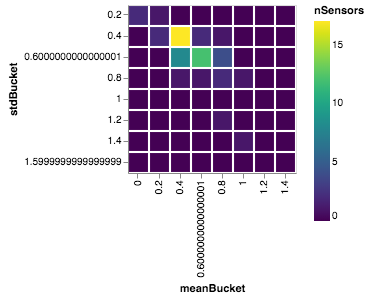

In [13]:
plotGrid(correlationGrid)

In [24]:
chosenIndex = 17

coordList = correlationGrid[correlationGrid.reset_index()['index'] == chosenIndex]
coordList.apply(lambda row: buildCoordsList(row['sensors'], row['nSensors']), axis=1)

# correlationGrid.apply(lambda row: buildCoordsList(row['sensors'], row['nSensors']), axis=1)

17    None
dtype: object

In [23]:
def plotBarChart(dataframe, sensorID):
    print(sensorID)
    chart = alt.Chart(dataframe.reset_index()).mark_bar().encode(
        alt.X('hour'),
        alt.Y('dbas', scale=alt.Scale(domain=(0,4))))
    
    display(chart)
    

    
def plotSensorPosition(lat, lng):
    folium_map = folium.Map(location=[lat, lng], zoom_start=12)
    folium.Marker([lat, lng]).add_to(folium_map)
    display(folium_map)
    

def printCorrelationPlot(dataframe, sensorID):
    
    print(sensorID)
    correlation_plot = alt.Chart(dataframe).mark_point().encode(
        x='mean',
        y='std',
        tooltip='sensorID'
    ).interactive()
    
    display(correlation_plot)
    
    
def plotGrid(dataframe):
    grid = alt.Chart(dataframe.reset_index()).mark_rect().encode(
        x='meanBucket:O',
        y='stdBucket:O',
        color='nSensors:Q',
        tooltip='index:N'
    )
    
    display(grid)
    
def plotMapPoints(listOfCoords, folium_map):
    
    folium_map = folium.Map(location=[40.758896, -73.985130], zoom_start=12)
    for coord in listOfCoords:
        folium.Marker([coord[0], coord[1]]).add_to(folium_map)
        
    display(folium_map)
    
def buildCoordsList(listOfSensors, nSensors):
    
    folium_map = folium.Map(location=[40.758896, -73.985130], zoom_start=12)
    
    coordList = []

    if nSensors != 0.0:
        for sensorID in listOfSensors:
            lat = sensorCoordinates[sensorCoordinates['sensorID'] == sensorID]['lat'].values[0]
            lng = sensorCoordinates[sensorCoordinates['sensorID'] == sensorID]['lng'].values[0]
            coordList.append([lat, lng])
            
            
        plotMapPoints(coordList, folium_map)
            
#     print(coordList)